In [35]:
import torch
import torchvision
import torchvision.transforms as transforms

In [36]:
# 获取数据集并进行处理
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 40 # batch个数
lr = 0.001 # 学习率
step_size = 10 # 每n个epoch更新学习率

# 从torchvision中获取CIFAR-10的训练集
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
# 分批                                        
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
                    
print(len(trainloader))

# 获取测试集
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
# 分批
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(len(testloader))

# 数据集中总的类别
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
1250
Files already downloaded and verified
250


In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [38]:
# 确定使用的模型

# from CNN import *
# # 使用原来的CNN模型
# net = CNN()

from VGG import *
# 使用VGG16模型
net = VGG16()

In [39]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9)
# 调整学习率
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5, last_epoch=-1)
epoch_num = 30
accuracy_rate = []

In [41]:
# 定义测试函数
def test():
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            outputs = net(images).to(device)
            outputs = outputs.cpu()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct // total
    accuracy_rate.append(accuracy)
    # print(f'Accuracy of the CNN on the test images: {accuracy} %')
    print(f'Accuracy of the VGG16 on the test images: {accuracy} %')

In [42]:
# 训练模型
print_num = int(len(trainset) // batch_size // 4) # 每n个输出一次损失率
print(print_num)
accuracy_rate = []
for epoch in range(epoch_num):
    net.train()
    net.to(device)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 情况参数梯度
        optimizer.zero_grad()

        # 前向传播
        outputs = net(inputs).to(device)
        # 反向传播，计算梯度
        loss = criterion(outputs, labels)
        loss.backward()
        # 更新参数
        optimizer.step()

        running_loss += loss.item()
        if i % print_num == print_num - 1:
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_num:.3f}')
            running_loss = 0.0
    scheduler.step()
    test()

print('Finished Training')

312
[1,   312] loss: 2.302
[1,   624] loss: 2.297
[1,   936] loss: 2.281
[1,  1248] loss: 2.214
Accuracy of the CNN on the test images: 23 %
[2,   312] loss: 2.085
[2,   624] loss: 1.945
[2,   936] loss: 1.856
[2,  1248] loss: 1.795
Accuracy of the CNN on the test images: 36 %
[3,   312] loss: 1.737
[3,   624] loss: 1.686
[3,   936] loss: 1.658
[3,  1248] loss: 1.627
Accuracy of the CNN on the test images: 40 %
[4,   312] loss: 1.587
[4,   624] loss: 1.547
[4,   936] loss: 1.532
[4,  1248] loss: 1.499
Accuracy of the CNN on the test images: 46 %
[5,   312] loss: 1.477
[5,   624] loss: 1.443
[5,   936] loss: 1.427
[5,  1248] loss: 1.425
Accuracy of the CNN on the test images: 48 %
[6,   312] loss: 1.387
[6,   624] loss: 1.378
[6,   936] loss: 1.359
[6,  1248] loss: 1.335
Accuracy of the CNN on the test images: 52 %
[7,   312] loss: 1.312
[7,   624] loss: 1.312
[7,   936] loss: 1.303
[7,  1248] loss: 1.278
Accuracy of the CNN on the test images: 53 %
[8,   312] loss: 1.254
[8,   624] los

In [43]:
# 保存训练模型
# PATH = './cifar_net.pth'
PATH = './cifar_vgg.pth'
torch.save(net.state_dict(), PATH)

times:  [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.]
accuracy:  [23, 36, 40, 46, 48, 52, 53, 54, 56, 58, 59, 59, 60, 61, 61, 61, 61, 61, 62, 62, 63, 63, 63, 63, 63, 63, 64, 63, 63, 64]


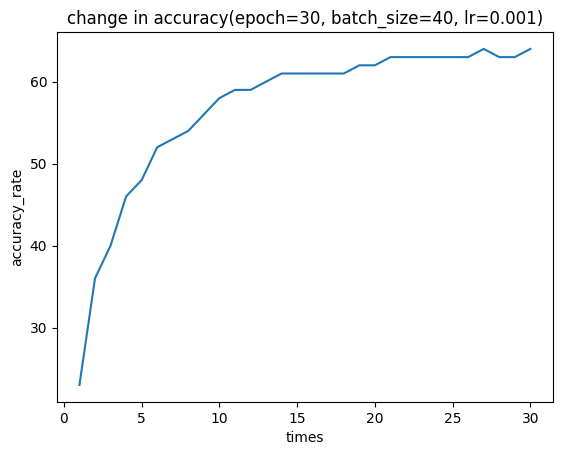

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# 画出分类准确率变化折线图
times = np.linspace(1, epoch_num, epoch_num)
print('times: ', times)
print('accuracy: ', accuracy_rate)
plt.title(f'change in accuracy(epoch={epoch_num}, batch_size={batch_size}, lr={lr})')
plt.xlabel('times')
plt.ylabel('accuracy_rate')
plt.plot(times, accuracy_rate)
plt.show()